In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from typing import Union
from tqdm.auto import tqdm as tqdm
from sklearn import preprocessing
import gc
import lightgbm as lgb
import random
import os
import re 
import lightgbm as lgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

In [2]:
# data = pd.read_pickle('all_data.pkl')
sample_submission = pd.read_csv('sample_submission.csv')
# data.shape

Because of the size of our data, we will be using LGB to do our modeling and feature selection.

In [3]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price,rolling_skew_t30,rolling_kurt_t30,year,quarter,month,week,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,bollinger,rrg_bench,rrg_item,ATR,ann_vol,entropy,beta,info_ratio,triple_exp,relative_vol,RS,gap_size,gap_start,number_of_gaps,rolling_max_14,rolling_max_180,rolling_max_30,rolling_max_60,rolling_max_90,rolling_mean_14,rolling_mean_180,rolling_mean_30,rolling_mean_60,rolling_mean_90,rolling_min_14,rolling_min_180,rolling_min_30,rolling_min_60,rolling_min_90,rolling_std_14,rolling_std_180,rolling_std_30,rolling_std_60,rolling_std_90,sales_lag_15,sales_lag_17,sales_lag_19,sales_lag_21,sales_lag_23,sales_lag_25,sales_lag_27,sales_lag_29,sales_lag_31,sales_lag_33,sales_lag_35,event,gap_placement
0,HOUSEHOLD_1_030_CA_4_validation,2031,5,2,3,0,0,2014-05-14,11415,0,0,1,4.968750,0.0,0.0,2014,2,5,20,2,0,0,0,0,0,0,0,0.0,5.0,5.0,3.0,18.234375,1.559570,0.0,0.000865,0.120850,0.0,0.0,921.0,4.0,1.0,1.0,4.0,2.0,3.0,4.0,0.428467,0.688965,0.466553,0.566895,0.677734,0.0,0.0,0.0,0.0,0.0,0.513672,0.976074,0.628906,0.789062,0.897461,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0,0.0
1,HOUSEHOLD_1_032_CA_4_validation,2032,5,2,3,0,2,2014-05-14,11415,0,0,1,10.859375,0.0,0.0,2014,2,5,20,2,0,0,0,0,0,0,0,2.0,5.0,5.0,3.0,18.234375,2.394531,0.0,0.021866,1.757812,0.0,0.0,921.0,4.0,1.0,5.0,5.0,5.0,5.0,5.0,1.286133,0.655762,1.566406,1.383789,1.311523,0.0,0.0,0.0,0.0,0.0,1.772461,1.154297,1.612305,1.290039,1.346680,1.0,5.0,2.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,0,0.0
2,HOUSEHOLD_1_033_CA_4_validation,2033,5,2,3,0,0,2014-05-14,11415,0,0,1,4.468750,0.0,0.0,2014,2,5,20,2,0,0,0,0,0,0,0,0.0,5.0,5.0,3.0,18.234375,1.156250,0.0,-0.008560,0.000000,0.0,0.0,921.0,4.0,1.0,0.0,2.0,0.0,2.0,2.0,0.000000,0.183350,0.000000,0.133301,0.177734,0.0,0.0,0.0,0.0,0.0,0.000000,0.441895,0.000000,0.389160,0.438965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,HOUSEHOLD_1_034_CA_4_validation,2034,5,2,3,0,1,2014-05-14,11415,0,0,1,3.970703,0.0,0.0,2014,2,5,20,2,0,0,0,0,0,0,0,1.0,5.0,5.0,3.0,18.234375,1.230469,0.0,-0.007103,0.878906,0.0,0.0,921.0,4.0,1.0,2.0,5.0,5.0,5.0,5.0,0.285645,0.438965,0.566895,0.500000,0.444336,0.0,0.0,0.0,0.0,0.0,0.611328,0.799316,1.194336,0.947754,0.900879,0.0,0.0,1.0,0.0,4.0,1.0,0.0,5.0,0.0,0.0,0.0,0,0.0
4,HOUSEHOLD_1_035_CA_4_validation,2035,5,2,3,0,0,2014-05-14,11415,0,0,1,4.628906,0.0,0.0,2014,2,5,20,2,0,0,0,0,0,0,0,0.0,5.0,5.0,3.0,18.234375,0.443115,0.0,-0.018326,0.000000,0.0,0.0,921.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.005554,0.000000,0.000000,0.011108,0.0,0.0,0.0,0.0,0.0,0.000000,0.074524,0.000000,0.000000,0.105408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [3]:
# ca_model = data.loc[data['state_id']==0]
# tx_model = data.loc[data['state_id']==1]
# wi_model = data.loc[data['state_id']==2]

# ca_model.to_pickle('ca_model.pkl')
# tx_model.to_pickle('tx_model.pkl')
# wi_model.to_pickle('wi_model.pkl')

In [3]:
data = pd.read_pickle('wi_model.pkl')

In [4]:
wi_items = '[A-Z]+_\d{1}\d?_\d+_TX\w+'
sample_submission = sample_submission.loc[sample_submission['id'].str.contains(wi_items)]
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
12196,HOBBIES_1_001_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12197,HOBBIES_1_002_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12198,HOBBIES_1_003_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12199,HOBBIES_1_004_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12200,HOBBIES_1_005_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
columns = [col for col in data.columns if col not in 
            ['id', 'demand', 'date', 'wm_yr_wk']]

In [6]:
x = data[data['date'] <= '2016-04-24']
y = x.sort_values('date')['demand']
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')
del data
gc.collect()

40

In [7]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
gc.collect()

20

In [8]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}

In [ ]:
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.101174	valid_1's l2: 0.297558
[200]	training's l2: 0.0800248	valid_1's l2: 0.285857


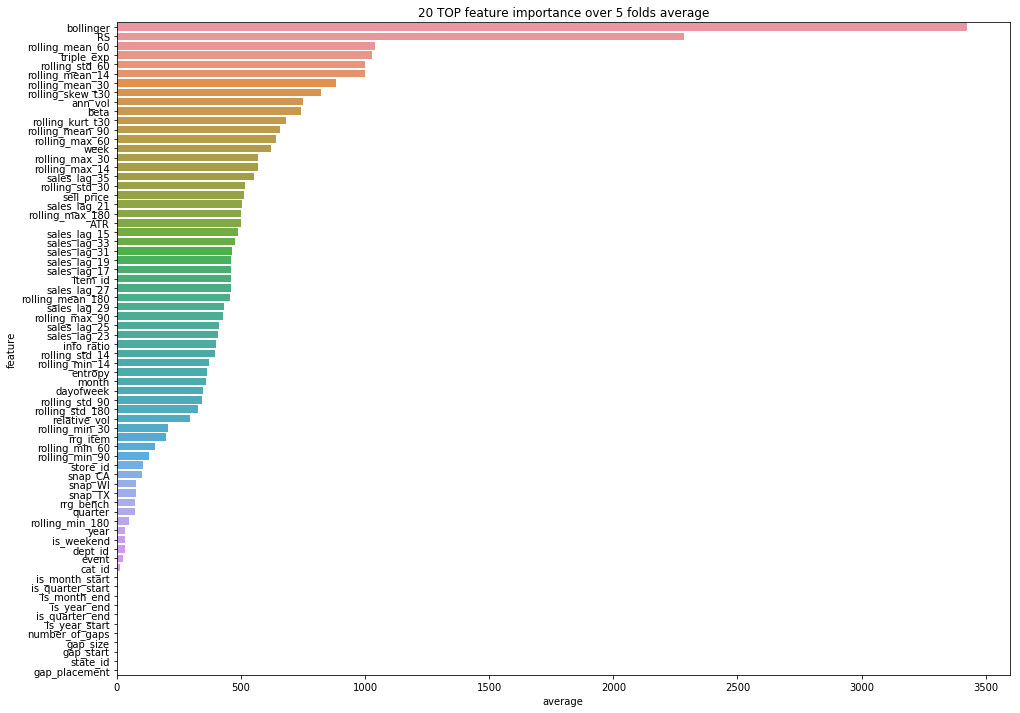

In [13]:
'''CA ITEM FEATURE IMPORTANCE'''

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

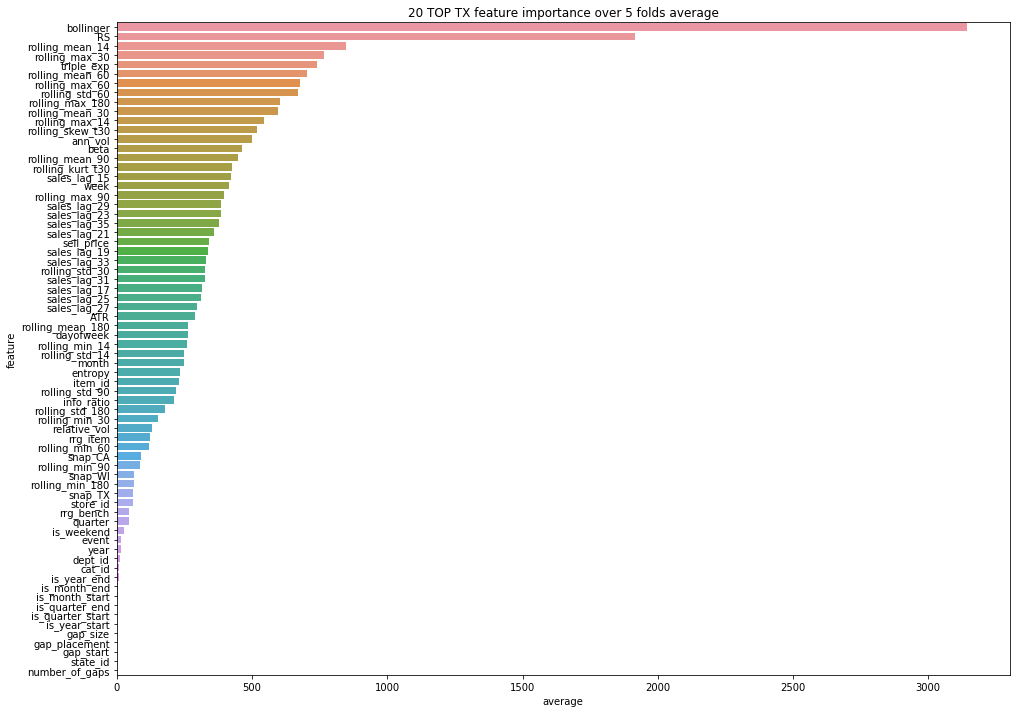

In [10]:
'''TX ITEM FEATURE IMPORTANCE'''
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('20 TOP TX feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
'''WI ITEM FEATURE IMPORTANCE'''
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('20 TOP TX feature importance over {} folds average'.format(folds.n_splits));

The following class/functions are thanks to https://www.kaggle.com/ragnar123/asymmetric-loss-functions-lgbm

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
def run_lgb(data, features, custom_asymmetric_train, custom_asymmetric_valid):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()
    

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train

    model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                      valid_sets = [train_set, val_set], verbose_eval = 100, fobj = custom_asymmetric_train, 
                      feval = custom_asymmetric_valid)
    
    val_pred = model.predict(x_val[features])
    y_pred = model.predict(test[features])
    x_val['demand'] = val_pred
    test['demand'] = y_pred
    x_val = x_val[['id', 'date', 'demand']]
    test = test[['id', 'date', 'demand']]

    return x_val, test

In [6]:
class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar.copy()
        self.prices = prices.copy()
        self.train_df = train_df.copy()
        self.valid_df = valid_df.copy()
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
    
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None
        

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [7]:
def evaluate(x_val, train_fold_df, valid_fold_df, calendar, sell_prices):
    x_val = pd.pivot(x_val, index = 'id', columns = 'date', values = 'demand').reset_index()
    x_val.columns = ['id'] + ['d_' + str(i) for i in range(1886, 1914)]
    x_val = train_fold_df[['id']].merge(x_val, on = 'id')
    x_val.drop('id', axis = 1, inplace = True)
    evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, sell_prices)
    score = evaluator.score(x_val)
    return score

def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)

In [8]:
# define cost and eval functions
def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2, 2 * 1.15)
    return grad, hess

def custom_asymmetric_valid(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2) , (residual ** 2) * 1.15) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [9]:
# seed everything
seed_everything(42)

features = [col for col in train.columns if col not in 
            ['id', 'demand', 'date', 'wm_yr_wk']]

In [11]:
# run model with asymmetric loss function
x_val, test = run_lgb(train, features, custom_asymmetric_train, custom_asymmetric_valid)
# predict test
predict(test, submission)

MemoryError: Unable to allocate array with shape (20372452, 70) and data type float64